In [2]:
import torch
from numpy.ma.core import size
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from model import FFN
from data_reader import SingleImageDataset

In [3]:
img_path = r'data/'

device = ("cuda"
      if torch.cuda.is_available()
      else "mps"
      if torch.backends.mps.is_available()
      else "cpu")

print(f"Using {device} device")

Using cuda device


In [4]:
lr = 1e-4
b_size = 128

In [5]:
net = FFN().to(device)

# Data loader
dataset = SingleImageDataset(img_path + 'image.png')
dataloader = DataLoader(dataset, batch_size=b_size, shuffle=False)

# We are training the network for pixels,
# so will do a pixelwise MSE loss
criterion = torch.nn.MSELoss()

# Optimizer and number of epochs
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
NUM_EPOCHS = 1000

In [6]:
loss_values = []

# train and store loss values
for epoch in range(NUM_EPOCHS):
  for batch in dataloader:
      x, y, actual = batch["x"], batch["y"], batch["intensity"]
      x = x / dataset.w # normalizing x between 0 and 1
      y = y / dataset.h # normalizing y between 0 and 1

      ### Assemble coord from x and y, pass to net, compute loss
      coord = torch.stack((x, y), dim=-1).to(device)
      pred = net(coord)
      loss = criterion(pred, actual.float().to(device))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  # Track loss
  loss_values.append(loss.item())
  avg_loss = sum(loss_values) / len(loss_values)
  print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {avg_loss}")

torch.save(net.state_dict(), img_path+'save_model.pt')

Epoch [1/1000], Loss: 0.004391209222376347
Epoch [2/1000], Loss: 0.004518719157204032
Epoch [3/1000], Loss: 0.004565694679816564
Epoch [4/1000], Loss: 0.004581991001032293
Epoch [5/1000], Loss: 0.004595502559095621
Epoch [6/1000], Loss: 0.004591366120924552
Epoch [7/1000], Loss: 0.004581420615847621
Epoch [8/1000], Loss: 0.004556666477583349
Epoch [9/1000], Loss: 0.004533590904126565
Epoch [10/1000], Loss: 0.00451447949744761
Epoch [11/1000], Loss: 0.004497414327819239
Epoch [12/1000], Loss: 0.0044955924386158586
Epoch [13/1000], Loss: 0.0045066950484537165
Epoch [14/1000], Loss: 0.004532688929300223
Epoch [15/1000], Loss: 0.00453861557568113
Epoch [16/1000], Loss: 0.004537706350674853
Epoch [17/1000], Loss: 0.0045417274403221465
Epoch [18/1000], Loss: 0.004543760118799077
Epoch [19/1000], Loss: 0.0045435110744284956
Epoch [20/1000], Loss: 0.004543487192131579
Epoch [21/1000], Loss: 0.004539625830061379
Epoch [22/1000], Loss: 0.004529624394225803
Epoch [23/1000], Loss: 0.00451947542150

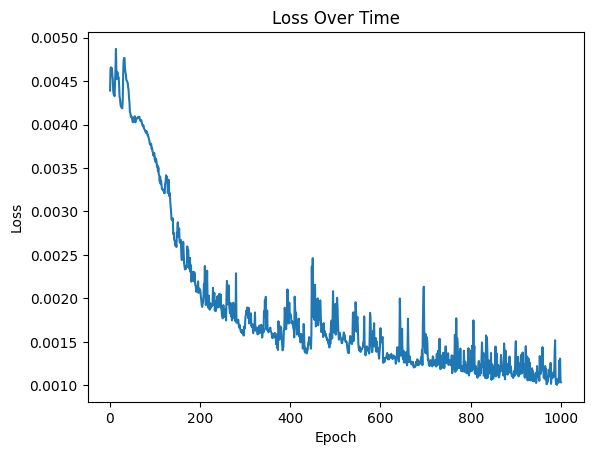

In [7]:
plt.plot(range(1, NUM_EPOCHS + 1), loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.show()

In [8]:
model_path = img_path + 'save_model.pt'
net.load_state_dict(torch.load(model_path))
net.eval()

FFN(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=3, bias=True)
  )
)

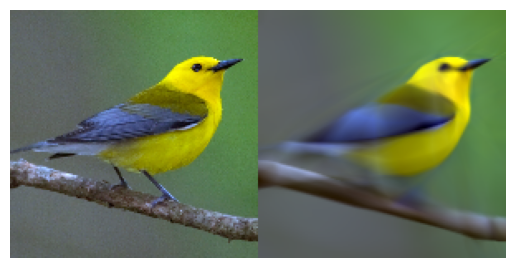

In [9]:
from torchvision.io import read_image

img = read_image(img_path+'image.png')

gt_image = torch.zeros(img.shape)
pred_image = torch.zeros(img.shape)

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
with torch.no_grad():
  for batch in dataloader:
    x, y, intensity = batch["x"], batch["y"], batch["intensity"]
    gt_image[:, y.item(), x.item()] = intensity*255

    x_ = x / dataset.w # normalizing x between 0 and 1
    y_ = y / dataset.h # normalizing y between 0 and 1

    coord = torch.stack((x_, y_), dim=-1)
    pred = net(coord.to(device))

    pred_image[:, y.item(), x.item()] = pred*255

pred_image = torch.clip(pred_image, 0, 255)

joint_image = torch.cat([gt_image.type(torch.uint8), pred_image.type(torch.uint8)], dim=2)
plt.imshow(joint_image.permute(1, 2, 0))
plt.axis('off')
plt.show()
plt.close()